# Building an ARIMA Model for a Financial Dataset

In this notebook, you will build an ARIMA model for AAPL stock closing prices. The lab objectives are:

* Pull data from <b>Google Cloud Storage/local storage,</b> into a Pandas dataframe
* Learn how to prepare raw stock closing data for an ARIMA model
* Apply the Dickey-Fuller test 
* Build an ARIMA model using the statsmodels library

In [0]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels

%config inlineBackend.figure_format = "retina"

## Import data from Google Clod Storage/local storage

In this section we'll read some ten years' worth of AAPL stock data into a Pandas dataframe. We want to modify the dataframe such that it represents a time series. This is achieved by setting the date as the index. 

In [3]:
df = pd.read_csv('AAPL10Y.csv')  
#df = pd.read_csv("gs://path-to-storage/AAPL10Y.csv")  #for cloud access

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


## Prepare data for ARIMA 

The first step in our preparation is to resample the data such that stock closing prices are aggregated on a weekly basis. 

In [4]:
df_week = df.resample("w").mean()
df_week = df_week[["close"]]
df_week.head()

,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


<Figure size 720x576 with 0 Axes>

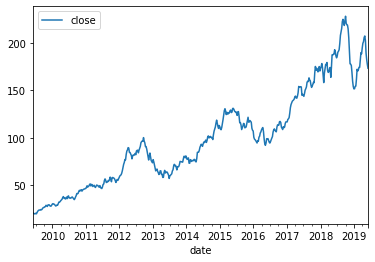

In [8]:
fig = plt.figure(figsize=(10,8))
df_week.plot()

Let's create a column for weekly returns. Take the log to of the returns to normalize large fluctuations.

In [9]:
df_week["weekly_ret"] = df_week["close"].diff()
df_week.head()

,close,weekly_ret
date,,
2009-06-07,20.445700,NaN
2009-06-14,20.106860,-0.338840
2009-06-21,19.525140,-0.581720
2009-06-28,19.711440,0.186300
2009-07-05,20.258925,0.547485


In [10]:
df_week.weekly_ret.describe([.25,.5,.75,.9,.99])

count    522.000000
mean       0.292824
std        3.107603
min      -14.026000
25%       -1.219000
50%        0.407280
75%        1.840129
90%        3.662900
99%        8.438600
max       13.110000
Name: weekly_ret, dtype: float64

In [11]:
df_week["weekly_ret"] = np.log(df_week["close"].diff())
df_week.weekly_ret.describe([.25,.5,.75,.9,.99])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


count    302.000000
mean       0.280939
std        1.159866
min       -4.866535
25%       -0.331888
50%        0.489019
75%        1.131189
90%        1.520204
99%        2.338015
max        2.573375
Name: weekly_ret, dtype: float64

In [12]:
df_week.dropna(inplace=True)
df_week.head()

,close,weekly_ret
date,,
2009-06-28,19.711440,-1.680397
2009-07-05,20.258925,-0.602420
2009-07-19,20.878880,0.243511
2009-07-26,22.256120,0.320081
2009-08-02,23.037400,-0.246822


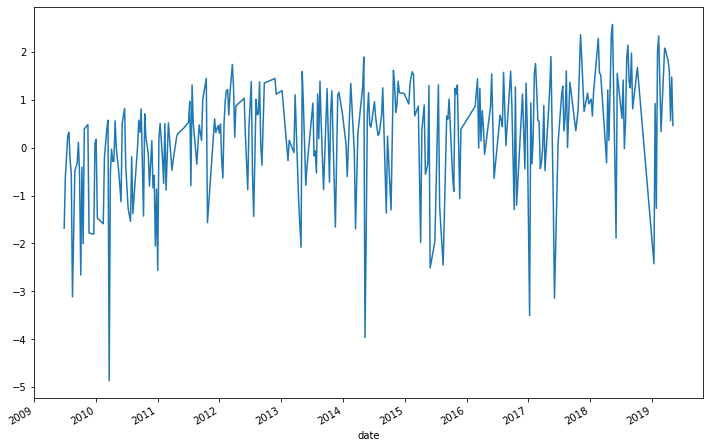

In [13]:
df_week.weekly_ret.plot(kind="line",figsize=(12,8))

In [14]:
udiff = df_week.drop(['close'], axis=1)
udiff.head()

,weekly_ret
date,
2009-06-28,-1.680397
2009-07-05,-0.602420
2009-07-19,0.243511
2009-07-26,0.320081
2009-08-02,-0.246822


In [0]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [0]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

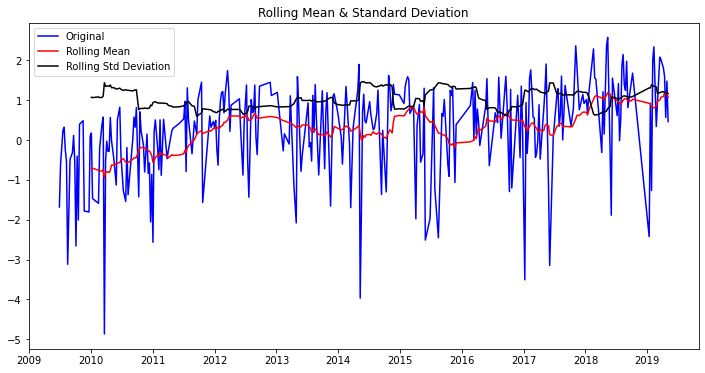

In [17]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [18]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                  -4.597694
p-value                          0.000130
#Lags Used                       4.000000
Number of Observations Used    297.000000
Critical Value (1%)             -3.452561
Critical Value (5%)             -2.871321
Critical Value (10%)            -2.571982
dtype: float64

With a p-value < 0.05, we can reject the null hypotehsis. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

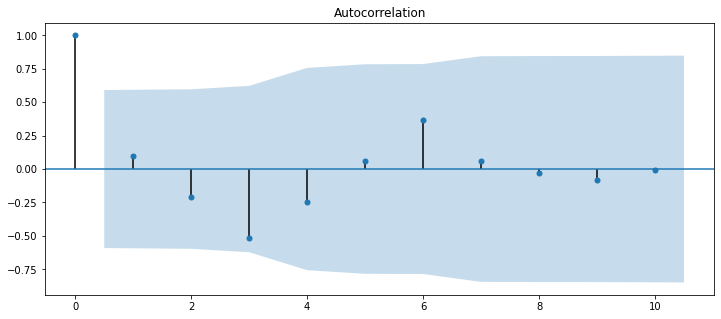

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff[:11].values, lags=10, ax=ax)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


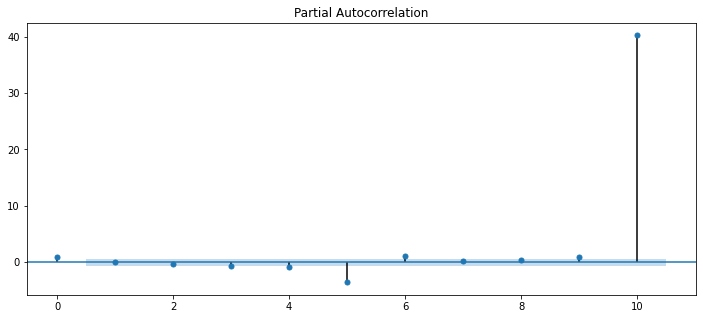

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff[:11].values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF.

<img src="/content/How_to_Read_PACF_ACF.jpg" alt="drawing" width="300" height="300"/>

The above chart shows that reading PACF gives us a lag "p" = 5 and reading ACF gives us a lag "q" of 3. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

## Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. 

In [23]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar1 = ARMA(tuple(udiff.values), (5, 3)).fit()
ar1.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountere

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  302
Model:                     ARMA(5, 3)   Log Likelihood                -446.721
Method:                       css-mle   S.D. of innovations              1.053
Date:                Fri, 10 Apr 2020   AIC                            913.442
Time:                        09:02:07   BIC                            950.546
Sample:                             0   HQIC                           928.288
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2568      0.388      0.663      0.508      -0.503       1.017
ar.L1.y       -0.5580        nan        nan        nan         nan         nan
ar.L2.y        0.4690        nan        nan        nan         nan         nan
ar.L3.y        0.8453        nan        nan        nan         nan         nan
ar.L4.y        0.0359        nan        nan        nan         nan         nan
ar.L5.y        0.1668        nan        nan        nan         nan         nan
ma.L1.y        0.7016      0.027     25.994      0.000       0.649       0.754
ma.L2.y       -0.4640      0.033    -13.942      0.000      -0.529      -0.399
ma.L3.y       -0.9090      0.025    -36.391      0.000      -0.958      -0.860
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8068           -0.5911j            1.0001           -0.3994
AR.2           -0.8068           +0.5911j            1.0001            0.3994
AR.3            1.0104           -0.0000j            1.0104           -0.0000
AR.4            0.1941           -2.4276j            2.4353           -0.2373
AR.5            0.1941           +2.4276j            2.4353            0.2373
MA.1            1.1001           -0.0000j            1.1001           -0.0000
MA.2           -0.8053           -0.5929j            1.0000           -0.3990
MA.3           -0.8053           +0.5929j            1.0000            0.3990
-----------------------------------------------------------------------------
"""

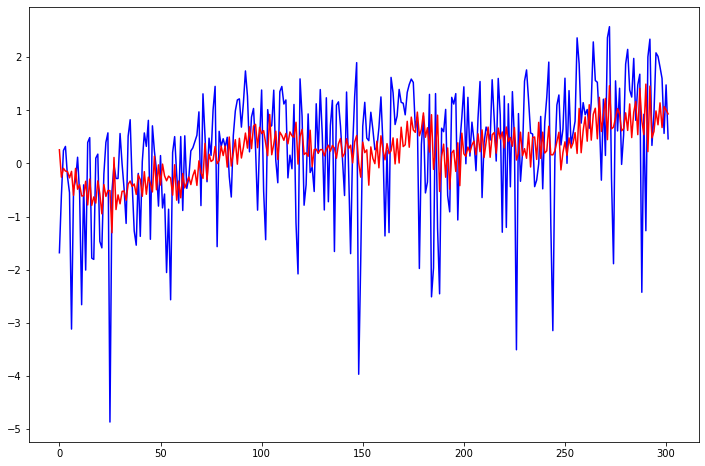

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

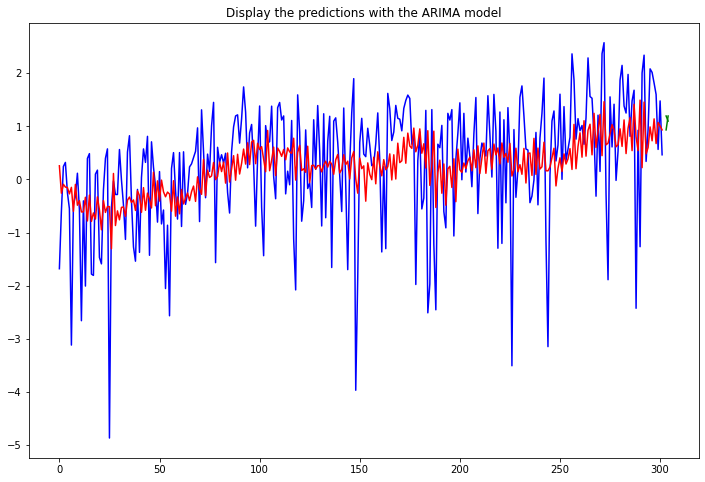

In [25]:
steps = 2

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.

In [28]:
from statsmodels.tsa.arima_model import ARIMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar2 = ARIMA(tuple(udiff.values), (5,1,3)).fit()
ar2.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  300
Model:                 ARIMA(5, 2, 3)   Log Likelihood                -453.298
Method:                       css-mle   S.D. of innovations              1.071
Date:                Fri, 10 Apr 2020   AIC                            926.596
Time:                        09:09:12   BIC                            963.633
Sample:                             2   HQIC                           941.418
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.657e-05   3.97e-05     -0.417      0.677   -9.44e-05    6.13e-05
ar.L1.D2.y    -0.9428      0.050    -18.678      0.000      -1.042      -0.844
ar.L2.D2.y    -0.0576      0.066     -0.879      0.380      -0.186       0.071
ar.L3.D2.y    -0.1014      0.071     -1.425      0.155      -0.241       0.038
ar.L4.D2.y     0.0797      0.082      0.969      0.333      -0.081       0.241
ar.L5.D2.y     0.0663      0.063      1.058      0.291      -0.057       0.189
ma.L1.D2.y    -0.9568      0.028    -34.079      0.000      -1.012      -0.902
ma.L2.D2.y    -1.0000      0.002   -583.562      0.000      -1.003      -0.997
ma.L3.D2.y     0.9568      0.028     34.454      0.000       0.902       1.011
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           -0.0000j            1.0000           -0.5000
AR.2            2.0877           -0.0000j            2.0877           -0.0000
AR.3            0.0147           -1.7652j            1.7653           -0.2487
AR.4            0.0147           +1.7652j            1.7653            0.2487
AR.5           -2.3190           -0.0000j            2.3190           -0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
MA.3            1.0452           +0.0000j            1.0452            0.0000
-----------------------------------------------------------------------------
"""